## DRAFT

In [8]:
nan = False
for i in range(int(len(data)/10)):
    data_selected = data.iloc[:i*10]
    for column in columns:
        if (~data_selected[column].isna()).sum()<THRESH_NAN:
            nan = True
            break
    if nan: 
        nan = False
        continue
    else:
        break

In [9]:
print('min not Nan values\t', THRESH_NAN)
print('dataset length\t\t', len(data_selected))
for column in columns:
    print(column,'\t\t', (~data_selected[column].isna()).sum())

min not Nan values	 3
dataset length		 1480
o_mus_ipr_LD 		 576
o_rat_orl_TDLo 		 19
o_mus_ipr_LDLo 		 37
o_mus_orl_TDLo 		 19
o_rat_ipr_TDLo 		 22
o_mus_ivn_LD 		 265
o_rat_ipr_LD 		 74
o_mus_orl_LD 		 536
o_mus_unr_LD 		 27
o_rat_unr_LD 		 5
o_mus_scu_LDLo 		 4
o_rat_scu_LD 		 26
o_mus_scu_LD 		 81
o_rat_ipr_LDLo 		 17
o_mus_ipr_TDLo 		 22
o_rbt_skn_LD 		 40
o_rat_orl_LD 		 168
o_rat_ivn_TDLo 		 6
o_rat_orl_LDLo 		 21
o_rbt_orl_LD 		 11
o_rbt_ivn_LD 		 3
o_rat_ivn_LD 		 23
o_mus_orl_LDLo 		 22
o_rat_skn_LD 		 15
o_mam_unr_LD 		 9
o_gpg_orl_LD 		 14
o_wmn_orl_TDLo 		 9
o_man_orl_TDLo 		 3
o_rat_scu_TDLo 		 5


# Code

In [30]:
import pandas as pd
import os
import torch
from torch.utils import data as td
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable#, Parameter

In [31]:
print(torch.__version__)

1.2.0


In [32]:
DATA_DIR = './database'
filename = 'MultiTox.csv'

## Get some data from overall dataset

In [33]:
def conformer_choice(props):
    probabilities=[props[key]['energy'] for key in props.keys()]
    conformer=np.random.choice(range(len(props)),1,probabilities)
    return np.asscalar(conformer)

In [34]:
data = pd.read_csv(os.path.join(DATA_DIR,filename))

In [35]:
columns = list(data)
columns.remove('SMILES')

In [36]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms as rdmt

In [37]:
#number of conformers created for every molecule
NUM_CONFS=100

#amount of chemical elements taking into account
AMOUNT_OF_ELEM=6

In [38]:
def create_element_dict(data,amount=9,treshold=10, add_H=False):
    elements={}
    norm=0
    for smile in data['SMILES']:
        molecule=Chem.MolFromSmiles(smile)
        molecule=Chem.AddHs(molecule)

        for i in range(molecule.GetNumAtoms()):
            atom = molecule.GetAtomWithIdx(i)
            element=atom.GetSymbol()
            norm+=1
            if element in elements.keys():
                elements[element]+=1
            else:
                elements[element]=1
    for key in elements.keys():
        elements[key]/=norm
    from collections import OrderedDict
    dd = OrderedDict(sorted(elements.items(), key=lambda x: x[1]))
    elements=list(dd.keys())[-amount:]  
    elements=dict((elem,i) for i, elem in enumerate(elements))  
    if not add_H:
        del elements['H']
    return elements

In [39]:
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM,add_H=True)

In [40]:
elements

{'Cl': 0, 'S': 1, 'N': 2, 'O': 3, 'C': 4, 'H': 5}

In [41]:
import load_data_multitox as ld
from sklearn.preprocessing import StandardScaler

In [42]:
DATASET_PATH='./'

In [43]:
conf_calc = ld.reading_sql_database(DATASET_PATH)

In [44]:
scaler = StandardScaler()
data[columns]=scaler.fit_transform(data[columns])

In [45]:
indexing, label_dict = ld.indexing_label_dict(data, conf_calc)

## Dataset

In [46]:
class Gauss_dataset(td.Dataset):
    def __init__(self,conf_calc,label_dict,elements,indexing, indexes,dx=0.5,dim=70):
        self.Xs=conf_calc
        self.Ys=label_dict
        self.elements=elements
        self.indexing = indexing
        self.dx = dx
#         self.sigma=sigma
#         self.dim=dim
#         self.dx=dx
#         self.kern_dim=kern_dim
        self.indexes=indexes
        self.dim = dim

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.indexes)

    def __getitem__(self, index):
        from math import floor
        'Generates one sample of data'
        dimelem = len(self.elements)
        
        cube=torch.zeros((dimelem,self.dim,self.dim,self.dim))
        
        i=self.indexes[index]
        smiles=self.indexing[i]
        
        y= self.Ys[smiles]

        description=self.Xs[smiles][conformer_choice(self.Xs[smiles])]['coordinates']
#         X = gaussian_blur(description,self.elements,sigma=self.sigma,dimx=self.dim,dx=self.dx,kern_dim=self.kern_dim)

        for atom in description.keys():
        
            num_atom=elements[atom]

            for x0,y0,z0 in description[atom]:
                cube[num_atom, max(0,min(self.dim-1,floor(self.dim/2+x0/self.dx))), max(0,min(self.dim-1,floor(self.dim/2+y0/self.dx))), max(0,min(self.dim-1,floor(self.dim/2+z0/self.dx)))]=1

        X= cube
        return X, y
    

In [47]:
VOXEL_DIM = 70
TARGET_NUM = 29
args={'BATCH_SIZE':10}

In [48]:
class Net(nn.Module):
    def __init__(self, dim=70, dx=0.5,kern_dim=50,num_elems=6, num_targets=12, batch_size=args['BATCH_SIZE'], elements=elements):
        super(Net, self).__init__()

        self.sigma = Parameter(6*torch.ones(num_elems).float().to(device),requires_grad=True)
#         self.sigma.
        
        # initialize dimensions
        self.dim = dim
        self.num_elems = num_elems
        self.num_targets = num_targets
        self.batch_size = batch_size
        self.elements=elements
        self.dx=dx
        self.kern_dim=kern_dim

        # create layers
        self.conv1 = nn.Conv3d(num_elems, 32, kernel_size=(3, 3, 3))
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, TARGET_NUM)

        # initialize dense layer's weights
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)

        self.convolution = nn.Sequential(
            self.conv1,
            self.pool1,
            nn.ReLU(),
            self.conv2,
            self.pool2,
            nn.ReLU(),
            self.conv3,
            self.pool3,
            nn.ReLU(),
            self.conv4,
            self.pool4,
            nn.ReLU()
        )

        def weights_init(m):
            if type(m) == nn.Conv3d:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        # initialize convolutional layers' weights
        self.convolution.apply(weights_init)
        
    def gaussian_blur (self, batch):#(molecule,elements,sigma=2,dimx=70,dx=0.5,kern_dim=50):
        from math import floor

        dimx=self.dim
        dx=self.dx
        kern_dim=self.kern_dim
        
        
        batch=batch.to(device)
        dimelem=len(elements)
#         cube=torch.zeros((dimelem,dimx,dimx,dimx))
        cube=torch.zeros(batch.shape)
        cube=cube.to(device)

        #build the kernel
#         x = torch.arange(-kern_dim/4,kern_dim/4,dx)
        
#         y = torch.arange(-kern_dim/4,kern_dim/4,dx)
#         z = torch.arange(-kern_dim/4,kern_dim/4,dx)
        x = torch.arange(-dimx/2,dimx/2)
        
        y = torch.arange(-dimx/2,dimx/2)
        z = torch.arange(-dimx/2,dimx/2)
        xx, yy, zz = torch.meshgrid((x,y,z))
        x=x.to(device)
        y=y.to(device)
        z=z.to(device)
        xx=xx.to(device)
        yy=yy.to(device)
        zz=zz.to(device)
#         print(xx)
#         kernel = torch.exp(-(xx**2 + yy**2 + zz**2)/(2*self.sigma**2))

#         for atom in molecule.keys():

#             num_atom=elements[atom]
        for idx,molecule in enumerate(batch):
            for num_atom in range(len(elements)):
                
#     #             print(xx.shape)
#     #             print(self.sigma.shape)
# #                 print(xx,yy,zz,self.sigma[num_atom])
#                 kernel = torch.exp(-(xx**2 + yy**2 + zz**2)/(2*self.sigma[num_atom]**2))
# #                 print(kernel)
                
                for x0,y0,z0 in molecule[num_atom].nonzero():
#                     cube = cube + torch.exp(-((xx-x0)**2 + (yy-y0)**2 + (zz-z0)**2)/(2*self.sigma[num_atom]**2))
                    cube[idx][num_atom] = cube[idx][num_atom] + torch.exp(-(xx**2 + yy**2 + zz**2)/(2*self.sigma[num_atom]**2))*torch.cos(2*np.pi/self.sigma[num_atom]*torch.sqrt(xx**2+yy**2+zz**2))
                    
#                     for i in range(cube.shape[2]):
#                         for j in range(cube.shape[3]):
#                             for k in range(cube.shape[2]):
#                                 cube[idx,num_atom,i,j,k]+=torch.exp(-((i-x0)**2 + (j-y0)**2 + (k-z0)**2)/(2*self.sigma[num_atom]**2))
# #                     print(x[0],x0,dimx)
#                     x0=x0.float()
#                     y0=y0.float()
#                     z0=z0.float()
#                     x_range=[max(floor(x[0]/dx+x0),0),min(floor(x[-1]/dx+x0+1),cube.shape[2])]
#                     y_range=[max(floor(y[0]/dx+y0),0),min(floor(y[-1]/dx+y0+1),cube.shape[3])]
#                     z_range=[max(floor(z[0]/dx+z0),0),min(floor(z[-1]/dx+z0+1),cube.shape[4])]
#                     coord_ranges=[x_range,y_range,z_range]
# #                     print(coord_ranges)
#                     for i in range(3):
#                         if coord_ranges[i][1]-coord_ranges[i][0]>50:
#                             coord_ranges[i][1]=coord_ranges[i][0]+50
#                     cube_part=cube[idx,num_atom,coord_ranges[0][0]:coord_ranges[0][1],
#                                    coord_ranges[1][0]:coord_ranges[1][1],
#                                    coord_ranges[2][0]:coord_ranges[2][1]]
# #                     print(cube.shape)
#                     kern_ranges=[[],[],[]]
#                     for i in range(3):
#                         if coord_ranges[i][0]==0:
#                             kern_ranges[i].append(kern_dim-cube_part.shape[i])
#                         else:
#                             kern_ranges[i].append(0)
#                         if coord_ranges[i][1]==cube.shape[i+1]:
#                             kern_ranges[i].append(cube_part.shape[i])
#                         else:
#                             kern_ranges[i].append(kern_dim)
                    
#                     new_kern = kernel[kern_ranges[0][0]:kern_ranges[0][1],
#                                                kern_ranges[1][0]:kern_ranges[1][1],
#                                                kern_ranges[2][0]:kern_ranges[2][1]]*1.0
#                     mask = torch.zeros_like(kernel)
#                     for i_k,i_c in zip(range(kern_ranges[0][0],kern_ranges[0][1]),range(coord_ranges[0][0],coord_ranges[0][1])):
#                         for j_k,j_c in zip(range(kern_ranges[1][0],kern_ranges[1][1]),range(coord_ranges[1][0],coord_ranges[1][1])):
#                             for k_k,k_c in zip(range(kern_ranges[2][0],kern_ranges[2][1]),range(coord_ranges[2][0],coord_ranges[2][1])):
# #                                 mask[i,j,k]=1
#                                 cube[idx,num_atom,i_c,j_c,k_c]+=kernel[i_k,j_k,k_k]
                                
# #                     new_kern=kernel[mask.byte()]
#                     f = (torch.exp(-((xx-x0)**2 + (yy-y0)**2 + (zz-z0)**2)/(2*self.sigma[num_atom]**2))).sum()
# # #                     f.backward()
#                     f = cube.sum()
#                     f.backward()
#                     print(self.sigma.grad)

#                     cube_part=cube_part+kernel[kern_ranges[0][0]:kern_ranges[0][1],
#                                                kern_ranges[1][0]:kern_ranges[1][1],
#                                                kern_ranges[2][0]:kern_ranges[2][1]]
                    

#                     cube[idx,num_atom,coord_ranges[0][0]:coord_ranges[0][1],
#                          coord_ranges[1][0]:coord_ranges[1][1],
#                          coord_ranges[2][0]:coord_ranges[2][1]]=cube_part
        
        return cube


    def forward(self, x):
        x_gauss = self.gaussian_blur(x)
#         f = x_gauss.sum()
#         f.backward()
#         print(self.sigma.grad)
#         x = x.to(device)
#         x_gauss=x_gauss.to(device)
        
        x_conv = self.convolution(x_gauss)
#         conv = nn.Conv3d(6, 32, kernel_size=(3, 3, 3)).to(device)
#         f = x_conv.sum()
#         f.backward()
#         print(self.sigma.grad)
        x_vect = x_conv.view(x.shape[0], -1)
        y1 = F.relu(self.fc1(x_vect))
        y2=self.fc2(y1)
        #         multi-label (not multi-class!) classification => sigmoid non-linearity
        return y2

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=VOXEL_DIM, num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, batch_size=args['BATCH_SIZE'])
print(model)
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Net(
  (conv1): Conv3d(6, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=29, bias=True)
  (convolution): Sequential(
    (0): Conv3d(6, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False

In [50]:
from sklearn.model_selection import train_test_split
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)


In [51]:
train_set = Gauss_dataset(conf_calc, label_dict, elements, indexing,train_indexes)
train_generator = td.DataLoader(train_set, batch_size=args['BATCH_SIZE'], shuffle=True)
test_set = Gauss_dataset(conf_calc, label_dict, elements, indexing, test_indexes)
test_generator = td.DataLoader(test_set, batch_size=args['BATCH_SIZE'], shuffle=False)

In [52]:
def test(model, test_generator,epoch,device,writer=None,f_loss=None):
#    print(f_auc is not None)
    with torch.no_grad():
        model.eval()
        test_loss = 0
        losses=np.zeros(TARGET_NUM)
        num_losses=np.zeros(TARGET_NUM)
        for batch_idx, (data, target) in enumerate(test_generator):
            data = data.to(device)
            target = target.to(device)
            output = model(data)   
            i=0
            for one_target,one_output in zip(target.cpu().t(),output.cpu().t()):
                with torch.no_grad():
                    mask = (one_target == one_target)
                    output_masked = torch.masked_select(one_output, mask).type_as(one_output)
                    target_masked = torch.masked_select(one_target, mask).type_as(one_output)
                    criterion=nn.MSELoss()
                    loss = criterion(output_masked.cpu(),target_masked.cpu())
                    if loss == loss:
                        losses[i]+=loss
                        num_losses[i]+=1
#                        if f_loss is not None:
#                            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss.cpu().numpy().item())+'\n')
                    i+=1
            mask = (target == target)
            output_masked = torch.masked_select(output, mask).type_as(output)
            target_masked = torch.masked_select(target, mask).type_as(output)
#            penalty_masked = torch.masked_select(PENALTY.to(device), mask).type_as(output)
#            class_weights=(1-penalty_masked)*(target_masked).to(device)+penalty_masked

            criterion=nn.MSELoss()
            loss = criterion(output_masked, target_masked)

            test_loss += loss
            
            
#            if f_loss is not None:
#                f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(loss.cpu().numpy().item())+'\n')
#            total += output_masked.shape[0]
        test_loss /= len(test_generator.dataset)
        test_loss *= args['BATCH_SIZE']

        print('\nTest set: Average loss: {:.4f}\n'
              .format(test_loss))
    if writer is not None:
        writer.add_scalar('Test/Loss/'+str(epoch), test_loss, epoch)
    losses/=num_losses    
    for i,loss in enumerate(losses):
        if f_loss is not None and loss == loss:
            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss)+'\n')
    return test_loss

In [53]:
def train(model, optimizer, train_generator, epoch, device, writer = None,f_loss=None,f_loss_ch = None):
    model.train()
    train_loss=0
    losses=np.zeros(TARGET_NUM)
    num_losses=np.zeros(TARGET_NUM)
    for batch_idx, (data, target) in enumerate(train_generator):
        data = data.to(device)
        target = target.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        output = model(data)
        i=0
        for one_target,one_output in zip(target.cpu().t(),output.cpu().t()):
            with torch.no_grad():
                
                mask = (one_target == one_target)
                output_masked = torch.masked_select(one_output, mask).type_as(one_output)
                target_masked = torch.masked_select(one_target, mask).type_as(one_output)
                criterion=nn.MSELoss()
                loss = criterion(output_masked.cpu(),target_masked.cpu())
                if loss == loss:
                    losses[i]+=loss
                    num_losses[i]+=1
#                        if f_loss is not None:
#                            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss.cpu().numpy().item())+'\n')
            i+=1
        # calculate output vector
        
        # create mask to get rid of Nan's in target
        mask = (target == target)
        output_masked = torch.masked_select(output, mask).type_as(output)
        target_masked = torch.masked_select(target, mask).type_as(output)
#        penalty_masked = torch.masked_select(PENALTY.to(device), mask).type_as(output)
#        pred = output_masked.ge(0.5).type_as(output)
#        try:
#            auc=roc_auc_score(target_masked.cpu().detach(),pred.cpu().detach())
#            if f_auc is not None:
#                f_auc.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(auc)+'\n')
#        except ValueError:
#            pass
        # multi-label (not multi-class!) classification=>binary cross entropy loss
#        class_weights=(1-penalty_masked)*(target_masked).to(device)+penalty_masked
        criterion=nn.MSELoss()
        loss = criterion(output_masked, target_masked)
        
        if f_loss is not None:
            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(loss.cpu().detach().numpy().item())+'\n')
        loss.backward()
        optimizer.step()
        train_loss+=loss.cpu().detach().numpy().item()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_generator.dataset),
                       100. * batch_idx / len(train_generator), loss.item()))
    train_loss /= len(train_generator.dataset)
    train_loss *= args['BATCH_SIZE']
    print('train loss average = ', train_loss)
    if writer is not None:
        writer.add_scalar('Train/Loss/'+str(epoch), train_loss, epoch)
    losses/=num_losses    
    for i,loss in enumerate(losses):
        if f_loss_ch is not None and loss==loss:
            f_loss_ch.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss)+'\n')

In [54]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [55]:
early_stopping = EarlyStopping(patience=25, verbose=True)
for epoch in range(1, 100000):
        try:
#            train(model, optimizer, train_generator_waves, epoch,device,f_auc=f_train_auc,f_loss=f_train_loss)
#            test(model, test_generator_waves,epoch, device,f_auc=f_test_auc,f_loss=f_test_loss)
            train(model, optimizer, train_generator, epoch, device)
            test_loss = test(model, test_generator,epoch, device)
        
        except KeyError:
            print('Key Error problem')
        early_stopping(test_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print(model.sigma)    
        torch.save(model.state_dict(), os.path.join('./', 'draft_model'))

Train Epoch: 1 [0/6658 (0%)]	Loss: 0.582649
Train Epoch: 1 [1000/6658 (15%)]	Loss: 0.617742
Train Epoch: 1 [2000/6658 (30%)]	Loss: 3.166605
Train Epoch: 1 [3000/6658 (45%)]	Loss: 0.485764
Train Epoch: 1 [4000/6658 (60%)]	Loss: 0.487602
Train Epoch: 1 [5000/6658 (75%)]	Loss: 0.539196
Train Epoch: 1 [6000/6658 (90%)]	Loss: 1.584494
train loss average =  0.892041042630613

Test set: Average loss: 0.8508

Validation loss decreased (inf --> 0.850753).  Saving model ...
Parameter containing:
tensor([6.0006, 5.9999, 6.0003, 6.0004, 5.9999, 5.9996], device='cuda:0',
       requires_grad=True)
Train Epoch: 2 [0/6658 (0%)]	Loss: 1.276624


KeyboardInterrupt: 

In [ ]:
{'Cl': 3.6, 'S': 3.7, 'N': 3, 'O': 2.8, 'C': -, 'H': 2.2}


In [310]:
for batch_idx, (data_inp, target) in enumerate(train_generator):
        data_inp = data_inp.to(device)
        target = target.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        output = model(data_inp)
#         f = output.sum()
#         f.backward()
#         print(model.sigma.grad)
        mask = (target == target)
        output_masked = torch.masked_select(output, mask).type_as(output)
        target_masked = torch.masked_select(target, mask).type_as(output)
        criterion=nn.MSELoss()
        loss = criterion(output_masked, target_masked)
        loss.backward()
        optimizer.step()
        print(model.sigma)

Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0001, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 6.0000, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0000, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0000, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9999, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0001, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter contai

In [217]:
sigma = Variable(torch.ones(5).float().to(device),requires_grad=True)
fc1 = nn.Sequential(nn.Linear(5, 5),nn.Linear(5,2)).to(device)
x=fc1(sigma)
f = x.sum()
f.backward()
print(sigma.grad)


tensor([ 0.2010, -0.4394,  0.1859, -0.3289, -0.4254], device='cuda:0')


In [153]:
x = torch.ones(5)

In [154]:
x  += sigma[2]*torch.ones(5)

In [160]:
f.backward()

In [159]:
sigma.grad

In [48]:
train_set[10][0].shape

torch.Size([6, 70, 70, 70])

In [42]:
import visualization as vis

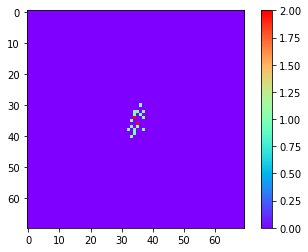

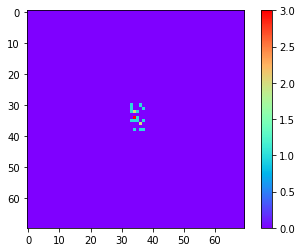

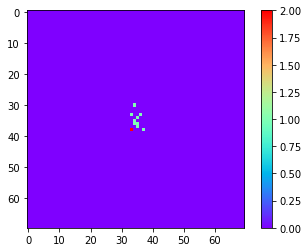

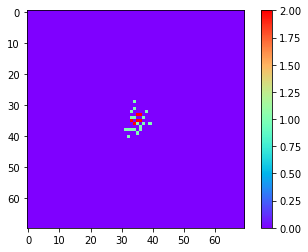

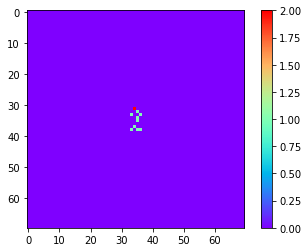

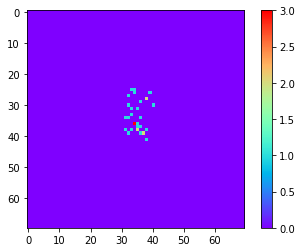

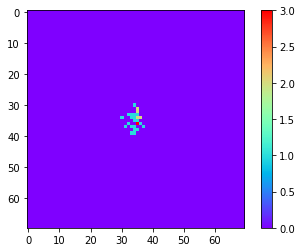

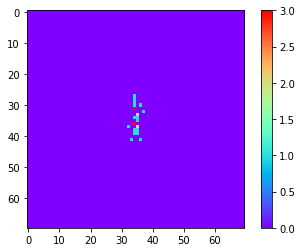

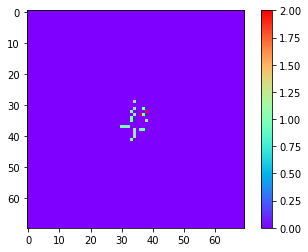

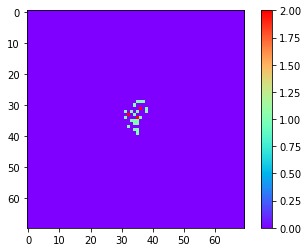

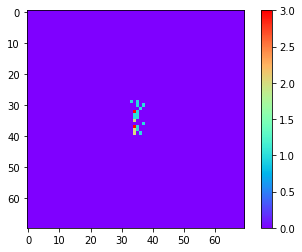

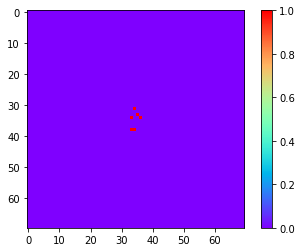

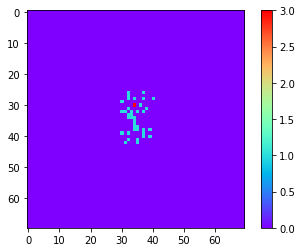

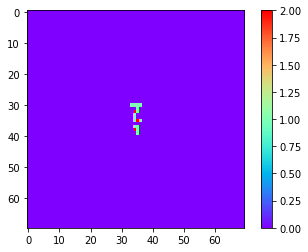

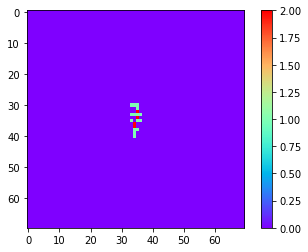

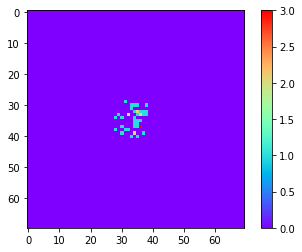

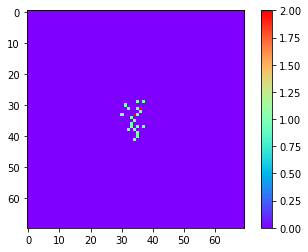

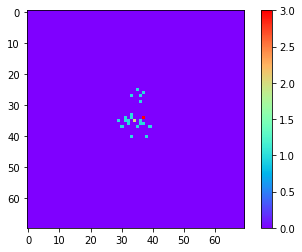

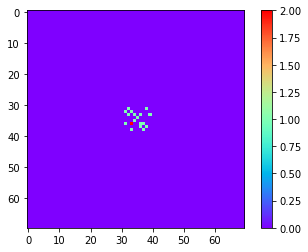

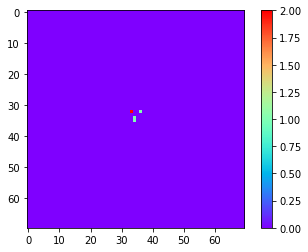

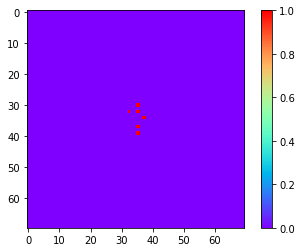

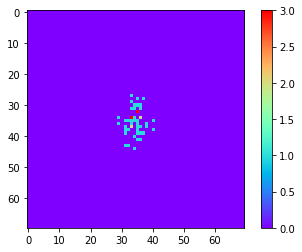

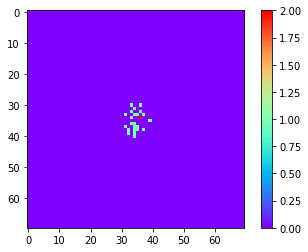

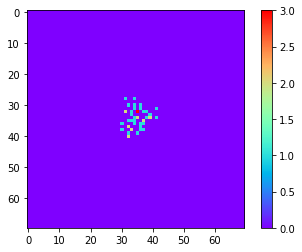

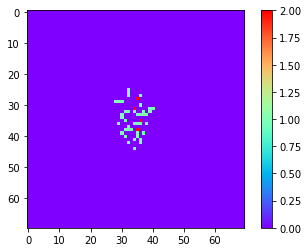

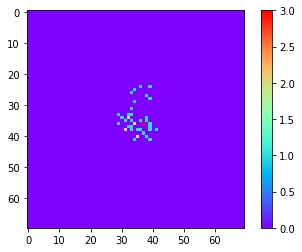

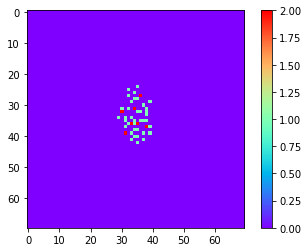

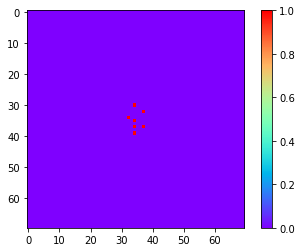

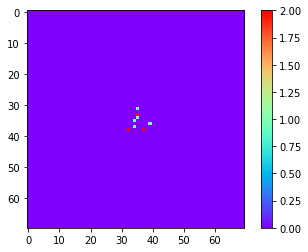

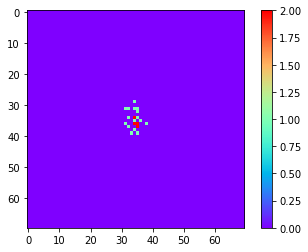

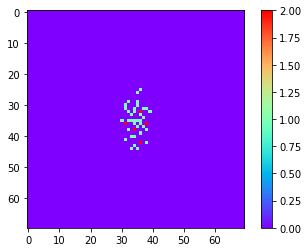

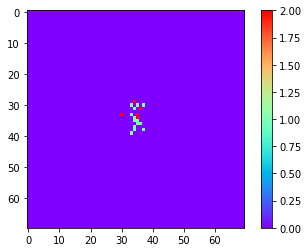

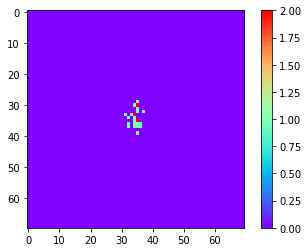

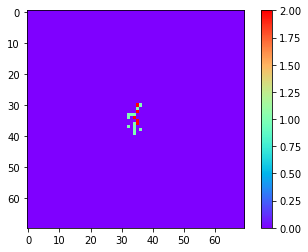

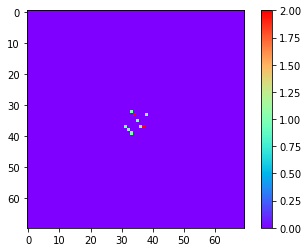

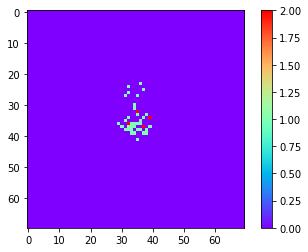

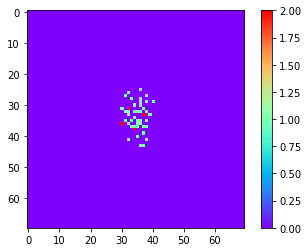

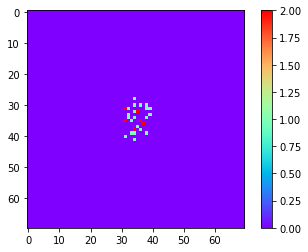

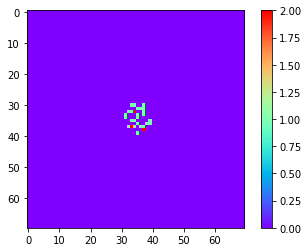

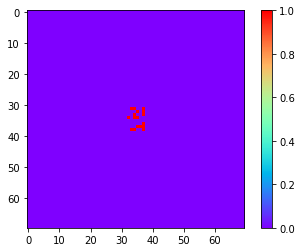

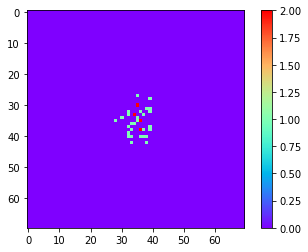

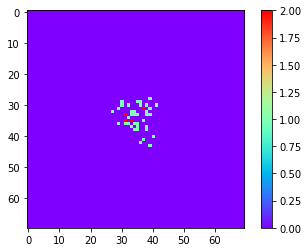

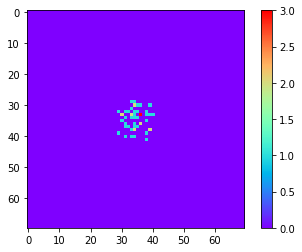

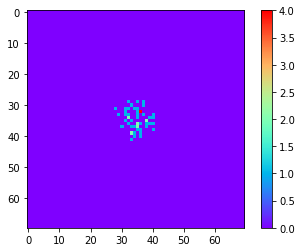

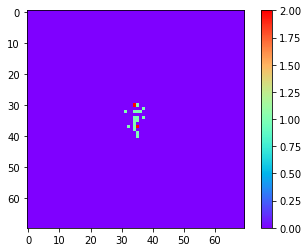

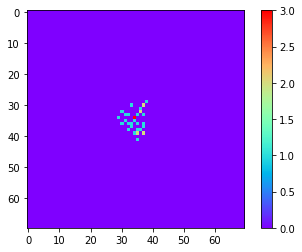

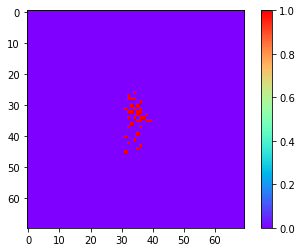

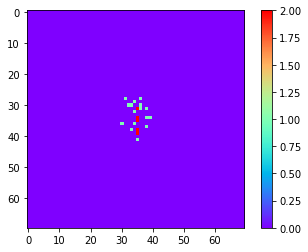

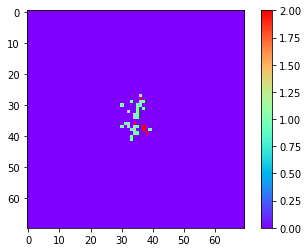

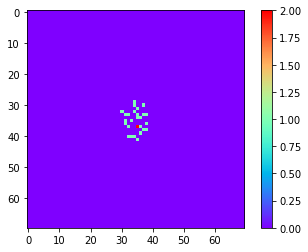

In [52]:
for i in range(50):
    vis.molecule_visualization2D(np.expand_dims(train_set[i][0].numpy().sum(axis=0).sum(axis=0),axis=0))

In [172]:
model.parameters()

<generator object Module.parameters at 0x7fa551c7eca8>

In [173]:
for f in model.parameters():
    print(f)
#     print('data is')
#     print(f.data)
#     print('grad is')
#     print(f.grad)

Parameter containing:
tensor([[[[[ 5.1371e-02,  3.8120e-02,  5.9627e-02],
           [-5.5404e-02, -1.4286e-02, -9.0682e-03],
           [-6.1930e-03,  4.4690e-02,  8.6186e-03]],

          [[ 6.2113e-02, -1.7580e-02, -7.3847e-02],
           [ 6.9574e-02,  3.9660e-02, -7.1597e-02],
           [-1.9775e-02, -5.6930e-02,  3.1993e-02]],

          [[ 6.2652e-02, -4.4029e-02, -6.2310e-02],
           [-5.3702e-03, -6.9392e-02,  2.4187e-02],
           [ 7.1772e-02, -2.4553e-02, -3.8751e-02]]],


         [[[-3.4688e-03,  2.0741e-02,  6.1599e-02],
           [ 2.7281e-02, -4.8626e-02, -5.5101e-02],
           [ 2.1256e-02,  2.6283e-02, -7.0569e-02]],

          [[-5.9242e-02,  6.8024e-02,  5.2904e-03],
           [ 3.1777e-02, -3.3375e-02, -3.7471e-02],
           [ 7.9789e-03,  4.7791e-02,  4.6652e-03]],

          [[-7.0653e-03, -5.3583e-02,  6.6849e-02],
           [-9.3354e-03,  9.9189e-03, -4.0019e-02],
           [-1.7245e-02,  6.1240e-02, -1.1306e-03]]],


         [[[ 3.1290e-03,  

In [174]:
model.sigma

tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)

In [75]:
data_inp,target = train_set[0]

In [87]:
data_inp.shape

torch.Size([6, 70, 70, 70])

In [96]:
data_inp[5].nonzero()

tensor([[ 1,  2,  2],
        [ 5, 67, 66],
        [ 7,  0, 65],
        [ 9, 67,  0],
        [ 9, 69,  2],
        [10,  1, 69],
        [59,  0, 69],
        [61, 66,  0],
        [63,  4, 69],
        [66, 65,  0],
        [67,  4, 69]])

In [57]:
elements

{'Cl': 0, 'S': 1, 'N': 2, 'O': 3, 'C': 4, 'H': 5}

In [126]:
model(data_inp)

AttributeError: 'Tensor' object has no attribute 'apply'

In [24]:
sigma = Parameter(torch.tensor(2).float().cuda(),requires_grad=True)

In [25]:
x=2*sigma#.sum()

In [26]:
x.backward()

In [27]:
sigma.grad

tensor(2., device='cuda:0')